## Importing standard libraries 

In [86]:
# Importing standard libraries

import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

from sklearn import preprocessing
import sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from matplotlib import pyplot as plt

## Reading data and preprocessing

In [2]:
df = pd.read_excel('/Users/rahulkhandelwal/Desktop/Code/customer_segmentation/customer_segmentation/Online Retail.xlsx')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Removing duplicate entries.

In [4]:
print('Duplicate entries: {}'.format(df.duplicated().sum()))
df.drop_duplicates(inplace = True)

Duplicate entries: 5268


Checking the total number of products, transactions and customers.

In [5]:
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,4070,25900,4372


Checking country wise distribution of transactions.

In [29]:
temp = df.groupby(['Country'],as_index=False).agg({'InvoiceNo':'nunique'}).rename(columns = {'InvoiceNo':'Orders'})
total = temp['Orders'].sum(axis=0)
temp['%Orders'] = round((temp['Orders']/total)*100,4)

In [30]:
temp.sort_values(by=['%Orders'],ascending=False,inplace=True)
temp.reset_index(drop=True,inplace=True)

In [85]:
temp[:10]

,Country,Orders,%Orders
0,United Kingdom,23494,90.7104
1,Germany,603,2.3282
2,France,461,1.7799
3,EIRE,360,1.3900
4,Belgium,119,0.4595
5,Spain,105,0.4054
6,Netherlands,101,0.3900
7,Switzerland,74,0.2857
8,Portugal,71,0.2741
9,Australia,69,0.2664


Removing cancelled orders from the data.

In [32]:
invoices = df['InvoiceNo']

In [33]:
x = invoices.str.contains('C', regex=True)
x.fillna(0, inplace=True)

In [34]:
x = x.astype(int)

In [35]:
x.value_counts()

0    527390
1      9251
Name: InvoiceNo, dtype: int64

In [36]:
df['order_canceled'] = x
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0


In [37]:
df['order_canceled'].value_counts()

0    527390
1      9251
Name: order_canceled, dtype: int64

In [38]:
n1 = df['order_canceled'].value_counts()[1]
n2 = df.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

Number of orders canceled: 9251/536641 (1.72%) 


In [42]:
df = df.loc[df['order_canceled'] == 0,:]

In [43]:
df.reset_index(drop=True,inplace=True)

Checking if we have negative quantities against any InvoiceNo.

In [44]:
df.loc[df['Quantity'] < 0,:]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled
2336,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom,0
4249,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,NaN,United Kingdom,0
7003,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,0
7004,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,0
7005,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,NaN,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
520928,581210,23395,check,-26,2011-12-07 18:36:00,0.0,NaN,United Kingdom,0
520930,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,NaN,United Kingdom,0
520931,581213,22576,check,-30,2011-12-07 18:38:00,0.0,NaN,United Kingdom,0
522503,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,NaN,United Kingdom,0


We find out that CustomerID values are missing for those customers which have negative quantity values. Therefore, we will remove them too.

In [45]:
df = df[df['CustomerID'].notna()]

In [46]:
df.reset_index(drop=True,inplace=True)

In [48]:
df_uk = df[df.Country == 'United Kingdom']

In [51]:
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0


In [88]:
df_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349227 entries, 0 to 392716
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   InvoiceNo       349227 non-null  object        
 1   StockCode       349227 non-null  object        
 2   Description     349227 non-null  object        
 3   Quantity        349227 non-null  int64         
 4   InvoiceDate     349227 non-null  datetime64[ns]
 5   UnitPrice       349227 non-null  float64       
 6   CustomerID      349227 non-null  float64       
 7   Country         349227 non-null  object        
 8   order_canceled  349227 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 26.6+ MB


## Cohort Analysis 

In [78]:
cohort_data = df_uk[['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']]

In [79]:
cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [80]:
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

cohort_data['InvoiceMonth'] = cohort_data['InvoiceDate'].apply(get_month)
grouping = cohort_data.groupby('CustomerID')['InvoiceMonth']
cohort_data['CohortMonth'] = grouping.transform('min')
cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01


In [81]:
def get_date_int(df, column):    
    year = df[column].dt.year    
    month = df[column].dt.month    
    day = df[column].dt.day
    return year, month, day

In [82]:
invoice_year, invoice_month, _ = get_date_int(cohort_data, 'InvoiceMonth') 
cohort_year, cohort_month, _ = get_date_int(cohort_data, 'CohortMonth')
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
cohort_data['CohortIndex'] = years_diff * 12 + months_diff
cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0


In [76]:
grouping = cohort_data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='CustomerID')
print(cohort_counts)

CohortIndex     0      1      2      3      4      5      6      7      8   \
CohortMonth                                                                  
2010-12-01   815.0  289.0  263.0  304.0  293.0  323.0  291.0  278.0  289.0   
2011-01-01   358.0   76.0   93.0   84.0  119.0   99.0   90.0   87.0  108.0   
2011-02-01   340.0   64.0   66.0   97.0   98.0   86.0   87.0   96.0   90.0   
2011-03-01   419.0   64.0  109.0   83.0   94.0   69.0  111.0   96.0  119.0   
2011-04-01   277.0   58.0   56.0   60.0   56.0   61.0   61.0   73.0   20.0   
2011-05-01   256.0   48.0   44.0   44.0   53.0   58.0   68.0   23.0    NaN   
2011-06-01   214.0   38.0   31.0   51.0   51.0   69.0   21.0    NaN    NaN   
2011-07-01   169.0   30.0   33.0   39.0   47.0   18.0    NaN    NaN    NaN   
2011-08-01   141.0   32.0   32.0   34.0   17.0    NaN    NaN    NaN    NaN   
2011-09-01   276.0   63.0   83.0   32.0    NaN    NaN    NaN    NaN    NaN   
2011-10-01   324.0   79.0   36.0    NaN    NaN    NaN    NaN    

What does this tell us?

Consider CohortMonth 2010-12-01: For CohortIndex 0, this tells us that 815 unique customers made transactions during CohortMonth 2010-12-01. For CohortIndex 1, this tells that there are 289 customers out of 815 who made their first transaction during CohortMonth 2010-12-01 and they also made transactions during the next month. That is, they remained active. For CohortIndex 1, this tells that there are 263 customers out of 815 who made their first transaction during CohortMonth 2010-12-01 and they also made transactions during the second-next month. And so on for higher CohortIndices.

Let us now calculate the Retention Rate. It is defined as the percentage of active customers out of total customers

In [77]:
cohort_sizes = cohort_counts.iloc[:,0]

#2.Divideallvaluesinthecohort_countstablebycohort_sizes
retention = cohort_counts.divide(cohort_sizes, axis=0)

#3.Reviewtheretentiontable
retention.round(3) * 100
print(retention)

CohortIndex   0         1         2         3         4         5         6   \
CohortMonth                                                                    
2010-12-01   1.0  0.354601  0.322699  0.373006  0.359509  0.396319  0.357055   
2011-01-01   1.0  0.212291  0.259777  0.234637  0.332402  0.276536  0.251397   
2011-02-01   1.0  0.188235  0.194118  0.285294  0.288235  0.252941  0.255882   
2011-03-01   1.0  0.152745  0.260143  0.198091  0.224344  0.164678  0.264916   
2011-04-01   1.0  0.209386  0.202166  0.216606  0.202166  0.220217  0.220217   
2011-05-01   1.0  0.187500  0.171875  0.171875  0.207031  0.226562  0.265625   
2011-06-01   1.0  0.177570  0.144860  0.238318  0.238318  0.322430  0.098131   
2011-07-01   1.0  0.177515  0.195266  0.230769  0.278107  0.106509       NaN   
2011-08-01   1.0  0.226950  0.226950  0.241135  0.120567       NaN       NaN   
2011-09-01   1.0  0.228261  0.300725  0.115942       NaN       NaN       NaN   
2011-10-01   1.0  0.243827  0.111111    

The first month's retention rate is 100%. This is because the number of active customers in the first month is actually the size of the cohort.

We can also calculate other metrics like the average quantity for each cohort.

In [83]:
grouping = cohort_data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='Quantity')
average_quantity.round(1)
average_quantity

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,11.363528,12.863370,13.931012,13.872916,13.343757,13.287995,14.274862,13.773035,16.144706,16.123957,16.672496,12.446232,14.462301
2011-01-01,18.080062,9.628663,9.442006,15.098384,10.089666,10.894436,13.554896,10.814691,10.757836,8.695507,8.592414,10.022152,NaN
2011-02-01,10.997248,14.049922,15.948747,12.122111,12.320763,11.928197,13.872105,13.721955,10.996767,12.542671,13.819477,NaN,NaN
2011-03-01,9.695935,11.430435,13.305280,10.086977,13.532950,12.837738,13.107456,14.062043,11.199703,9.734098,NaN,NaN,NaN
2011-04-01,10.068291,10.156757,9.720736,11.940795,11.863813,8.262323,9.873959,9.363861,7.477707,NaN,NaN,NaN,NaN
2011-05-01,10.657960,9.392857,14.841623,12.800244,11.045652,8.307816,10.816216,126.911243,NaN,NaN,NaN,NaN,NaN
2011-06-01,9.549744,14.785714,11.980276,12.738017,9.818008,8.891049,9.350254,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,10.145833,14.984576,6.572790,8.112313,5.778264,6.683406,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,9.393834,6.029240,5.028132,5.909297,6.558894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let us now visualize the retention rates by a heatmap.

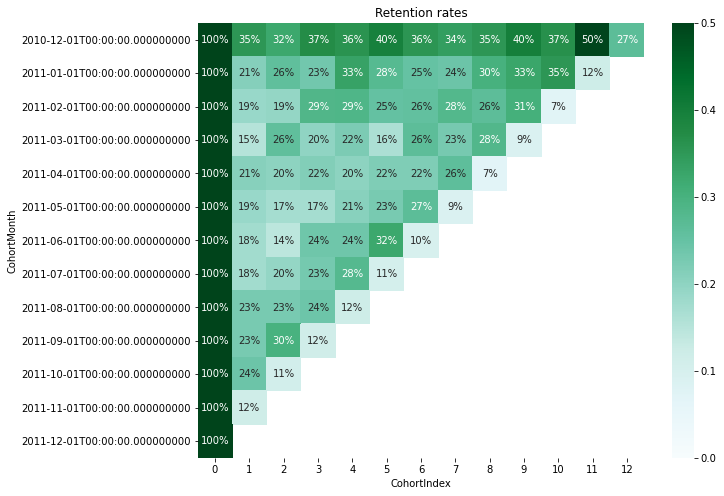

In [87]:
plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data = retention,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap = 'BuGn')
plt.show()

## RFM Segmentation 